In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [2]:
base_path = './../../'
sys.path.insert(0, base_path)
from Model import *

In [3]:
model = Model.Initialize('vae', None, pretrained_path=f'{base_path}Models/scvis_housing.pt')

Loading the pretrained model...


In [4]:

path = f'{base_path}/ELDR/Housing/Data/'


data_file = path + 'X.tsv'
target_file = path + 'y.tsv'
input_dim = 13
num_clusters = 6

x = pd.read_csv(data_file, sep="\t").values
y = pd.read_csv(target_file, sep="\t").values



data_rep = model.Encode(x)

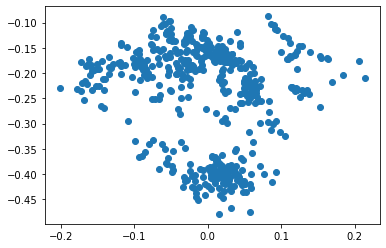

In [5]:
plt.scatter(data_rep[:,0], data_rep[:,1])
plt.show()

In [6]:
from sklearn.cluster import KMeans
num_clusters = 6

# rep = model.Encode(x)
kmeans = KMeans(n_clusters = num_clusters).fit(data_rep)

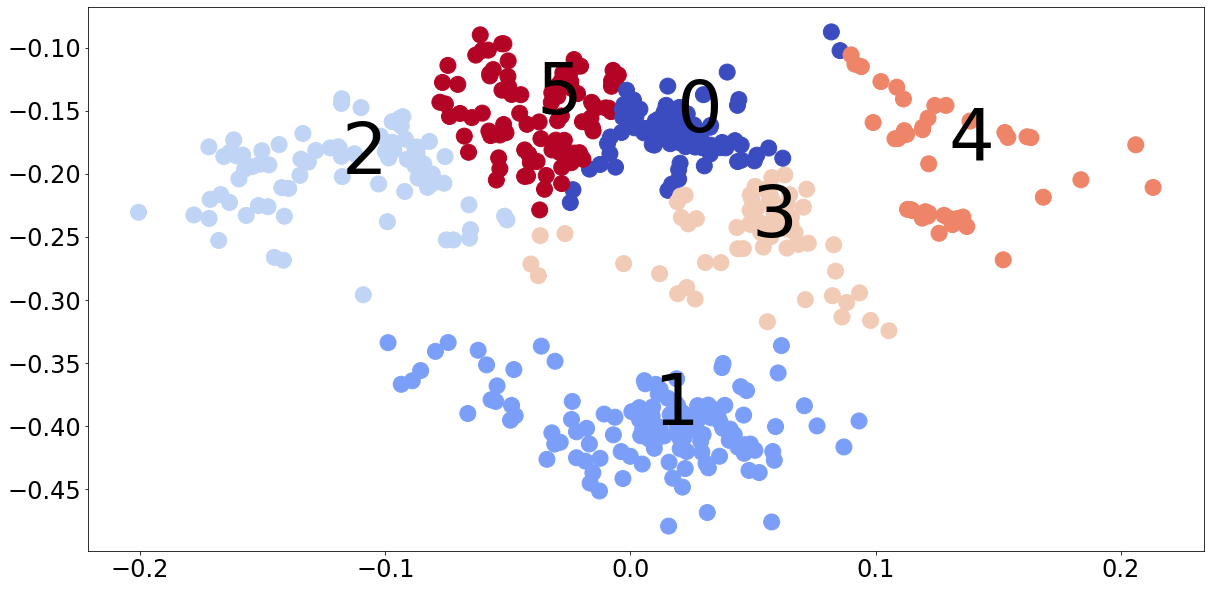

In [7]:
from eldr.plotter.myplot import *
means, centers, indices = plot_groups(x, data_rep.numpy(), num_clusters, kmeans.labels_, name = "./synth-rep.png")

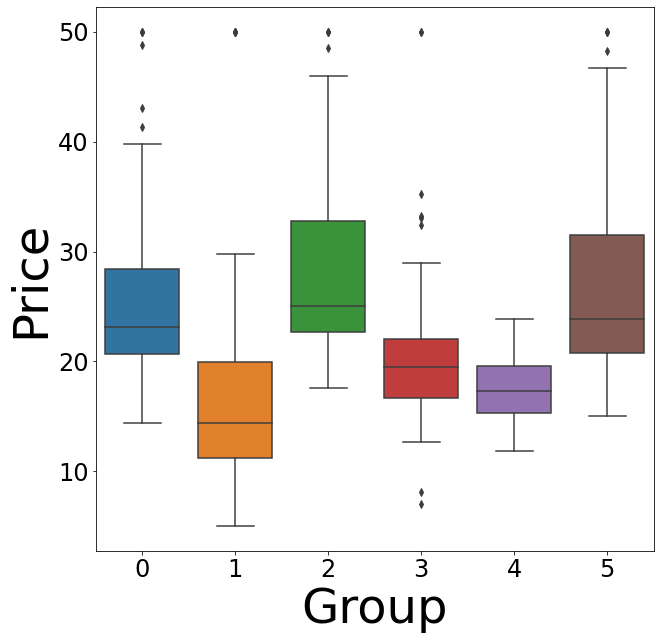

In [8]:
# See what signal is enocded in the clusters
import matplotlib.pyplot as plt
import seaborn as sns

labels = kmeans.labels_

fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(ax = ax, x = labels, y = np.squeeze(y))
ax.set(xlabel = "Group", ylabel = "Price")
ax.get_figure().savefig("housing-labels.png")


In [9]:
from eldr.explain.explain_cs import *
epsilon = 0.045

Explainer = Explain(model, means, centers, use_scaling=True)

if True:
    print(Explainer.eval_epsilon(torch.tensor(x), indices, epsilon))
    

(1.0, 1.0, 1.0)


In [11]:
results_path = f'{base_path}experiments/Housing/deltas/'
run = False

K = [1, 3, 5, 7, 9, 11, 13]


In [12]:
import json
from types import SimpleNamespace
config = SimpleNamespace(**json.load(open(f'{base_path}configs/tgt.json', 'r')))


[[ 0.13833542  0.17478527 -0.14527242  0.11164882  0.01421412 -0.03994629
   0.38086978  0.07122037  0.2779745   0.38864487  0.3392638  -0.10252612
   0.16714653]
 [ 0.04928435  0.10084599 -0.00754521 -0.02408748 -0.34887815  0.09714167
  -0.09906585  0.18978667  0.11009108  0.02721991 -0.16767356 -0.02192698
   0.00168947]
 [ 0.01731522  0.01128317 -0.0780794   0.09027719  0.08344641 -0.02522502
   0.10889904 -0.02574353  0.0474328   0.12575269  0.12489419 -0.01892886
   0.01859083]
 [-0.03401248 -0.06746124 -0.01236834  0.05123257  0.25272125 -0.08481123
   0.05941653 -0.14120151 -0.08912089  0.02338224  0.15185349  0.01582437
  -0.02283863]
 [-0.01287229  0.00226339  0.03542247 -0.04704434 -0.1553984   0.04044517
  -0.10991529  0.06160311  0.01925639 -0.07076867 -0.14066547  0.00280084
  -0.01646909]]


./../../eldr/plotter/myplot.py:106: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/home/jim/anaconda3/envs/factai/lib/python3.8/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


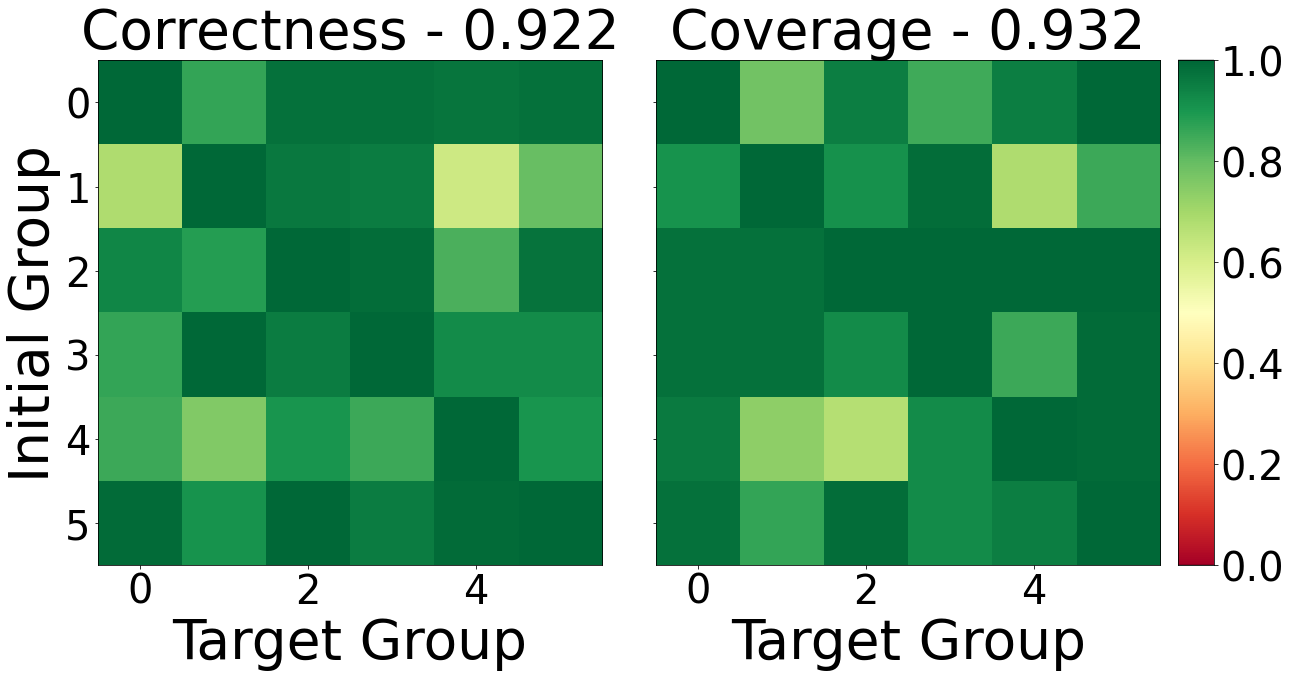

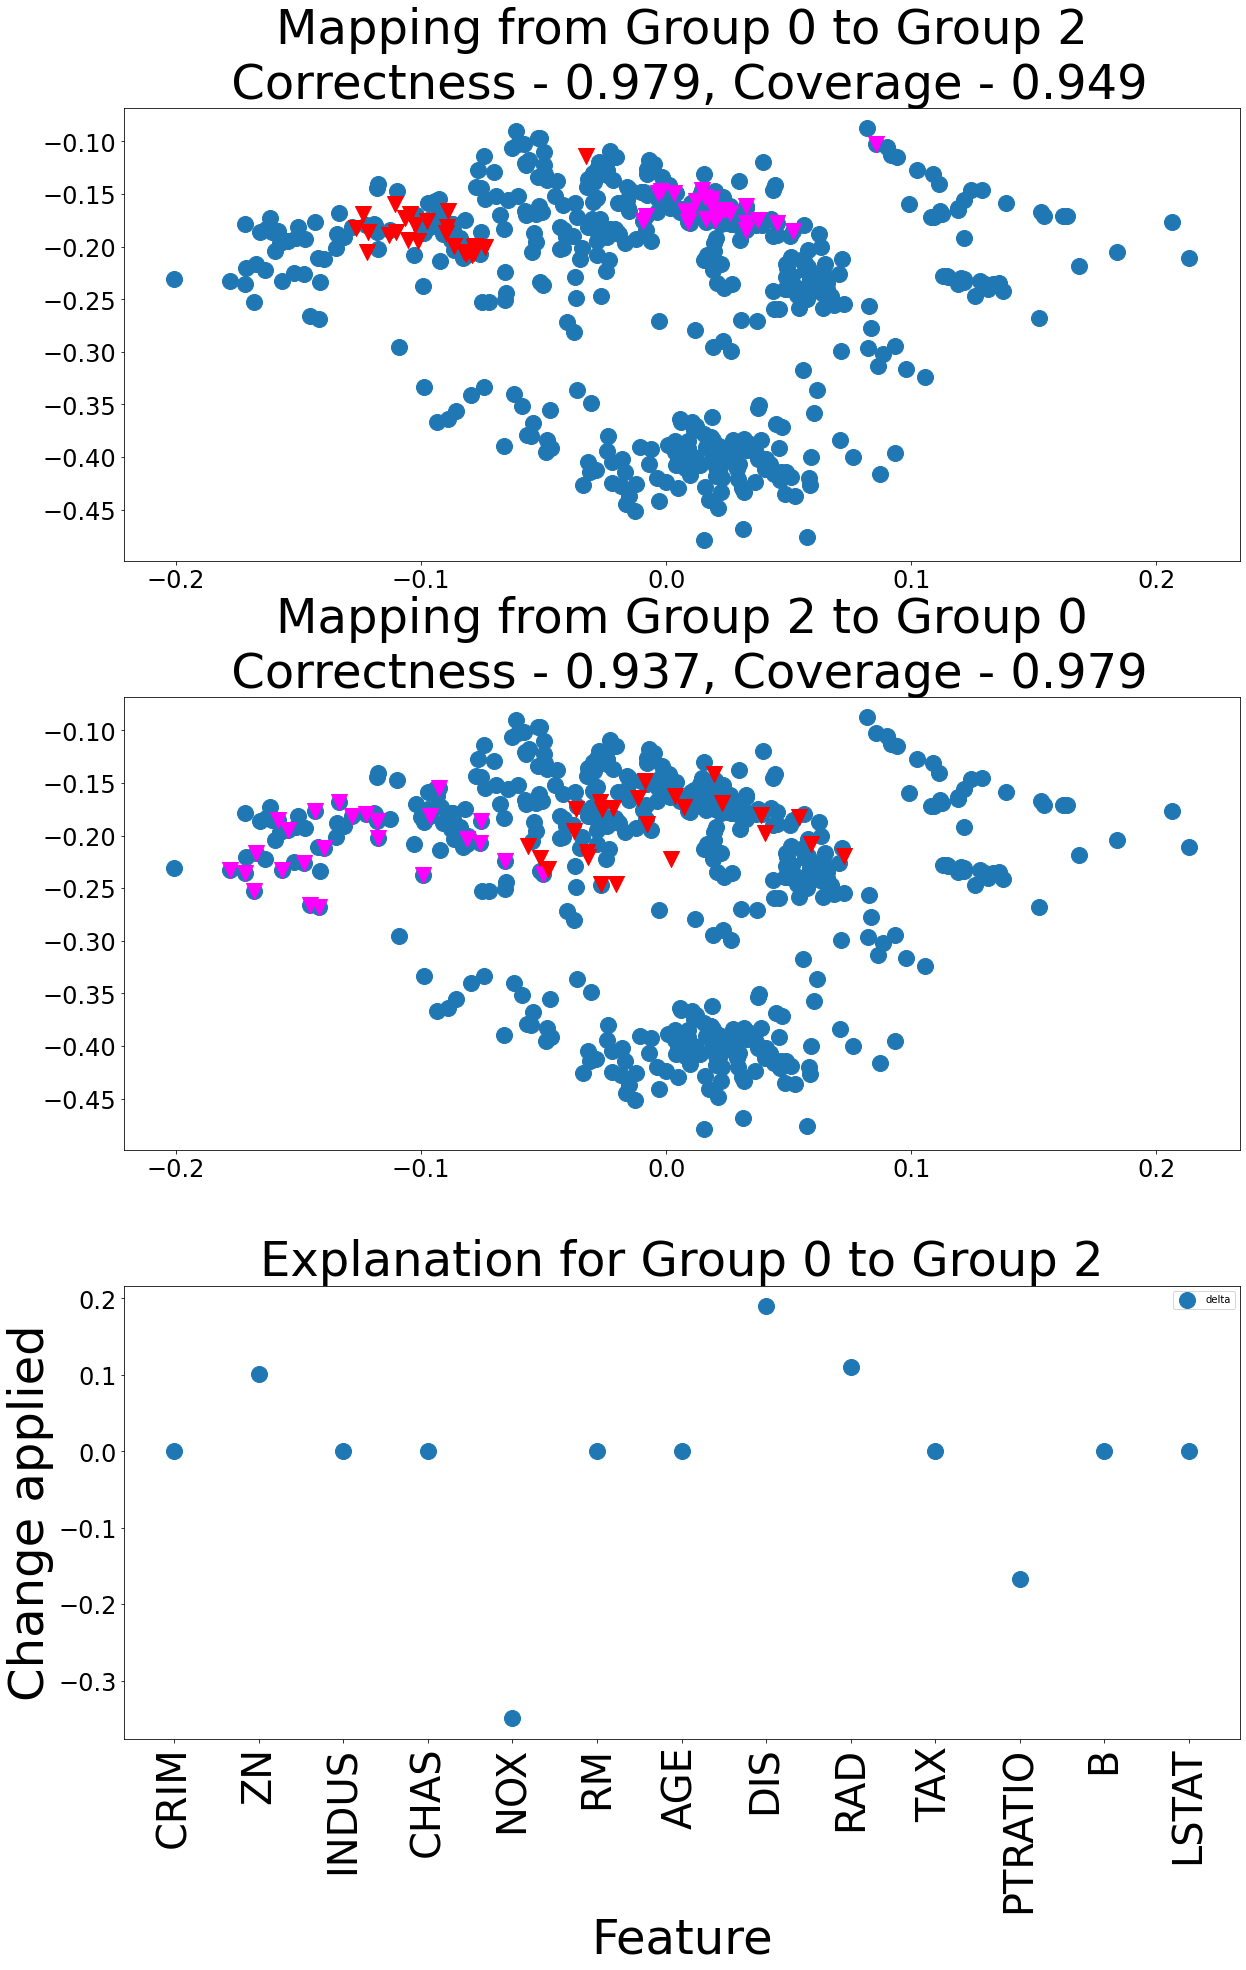

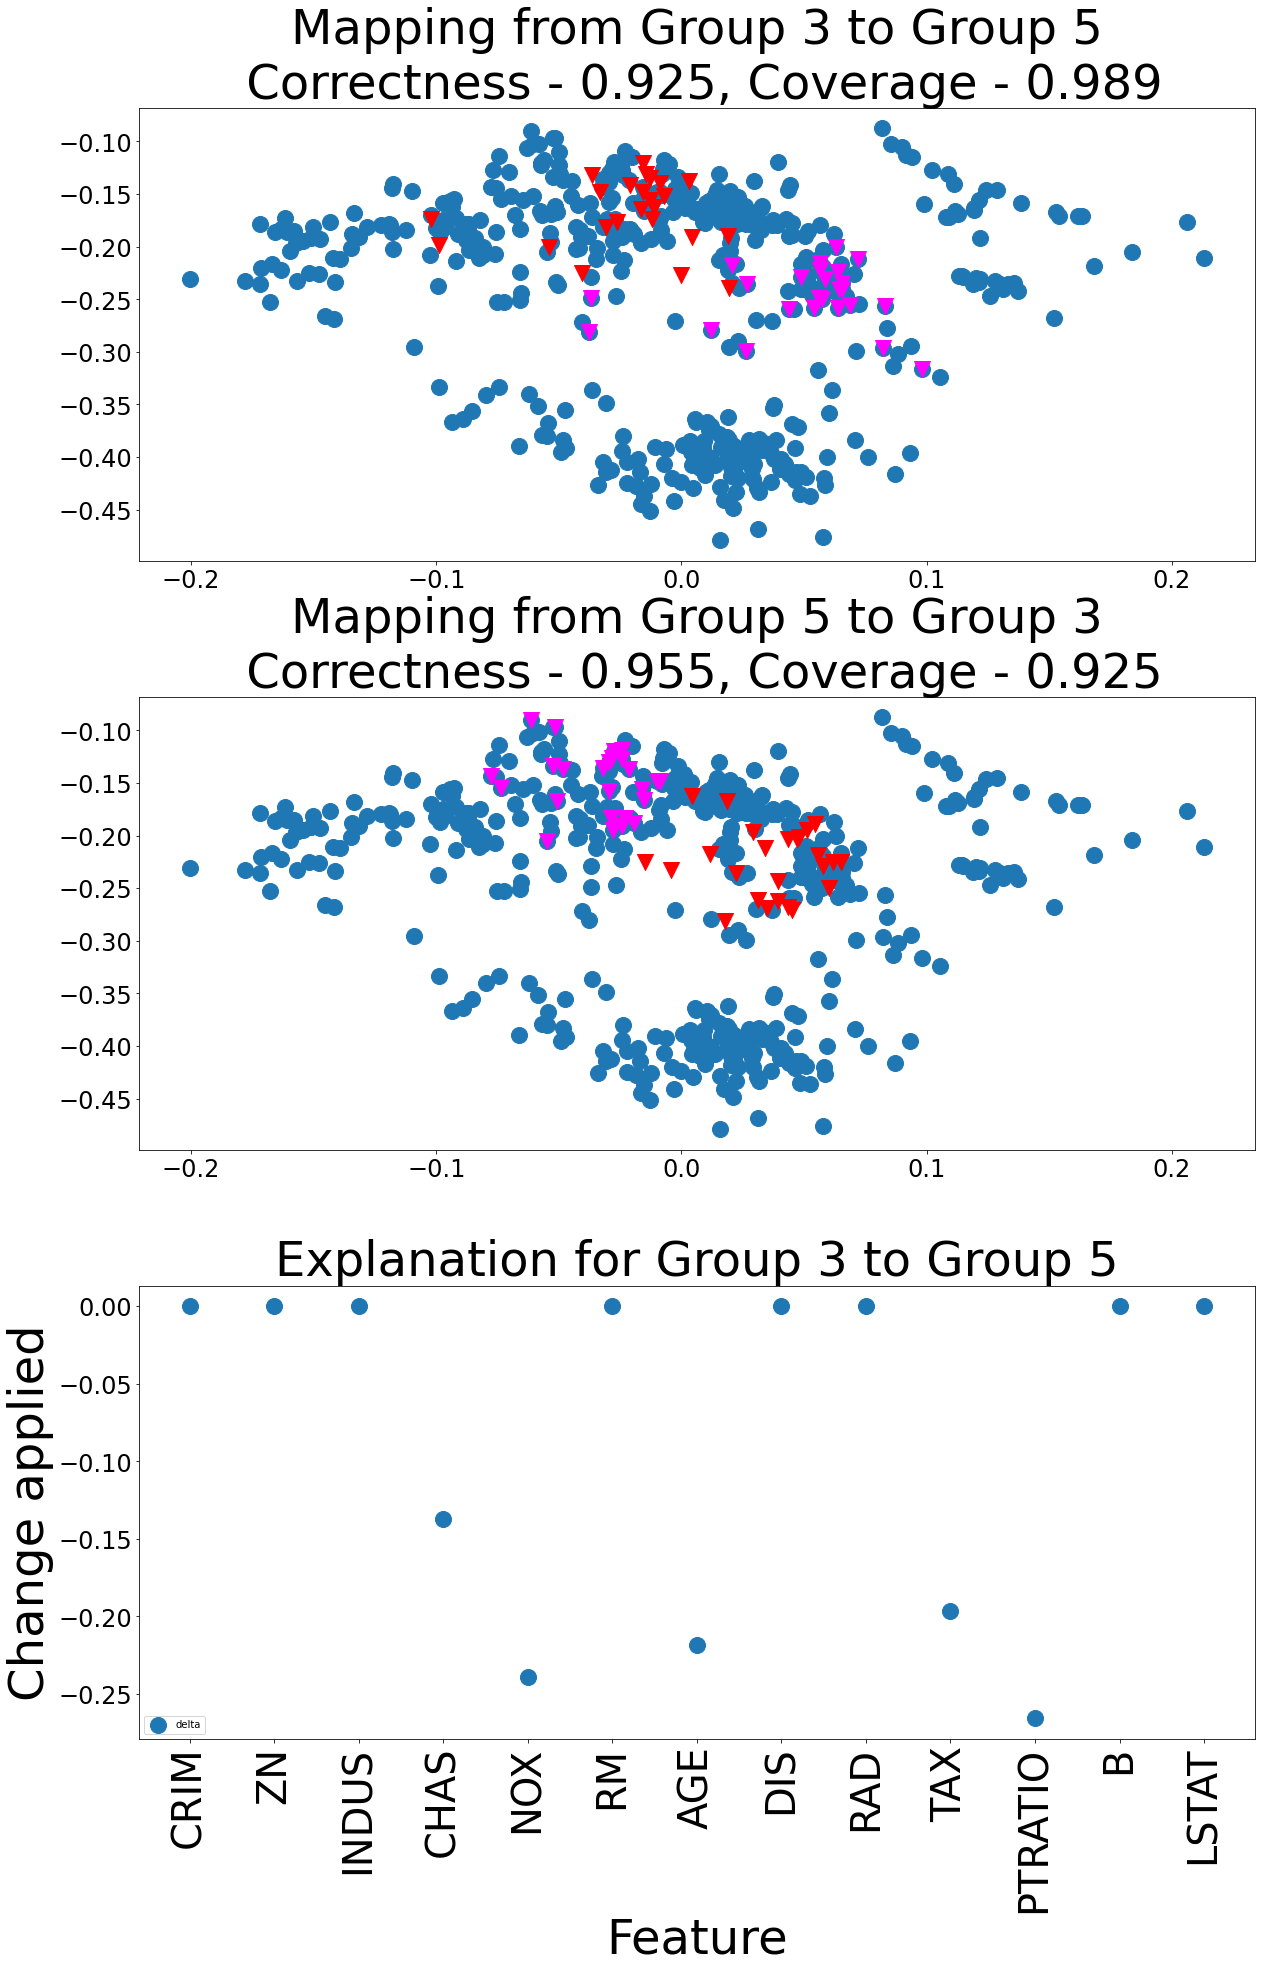

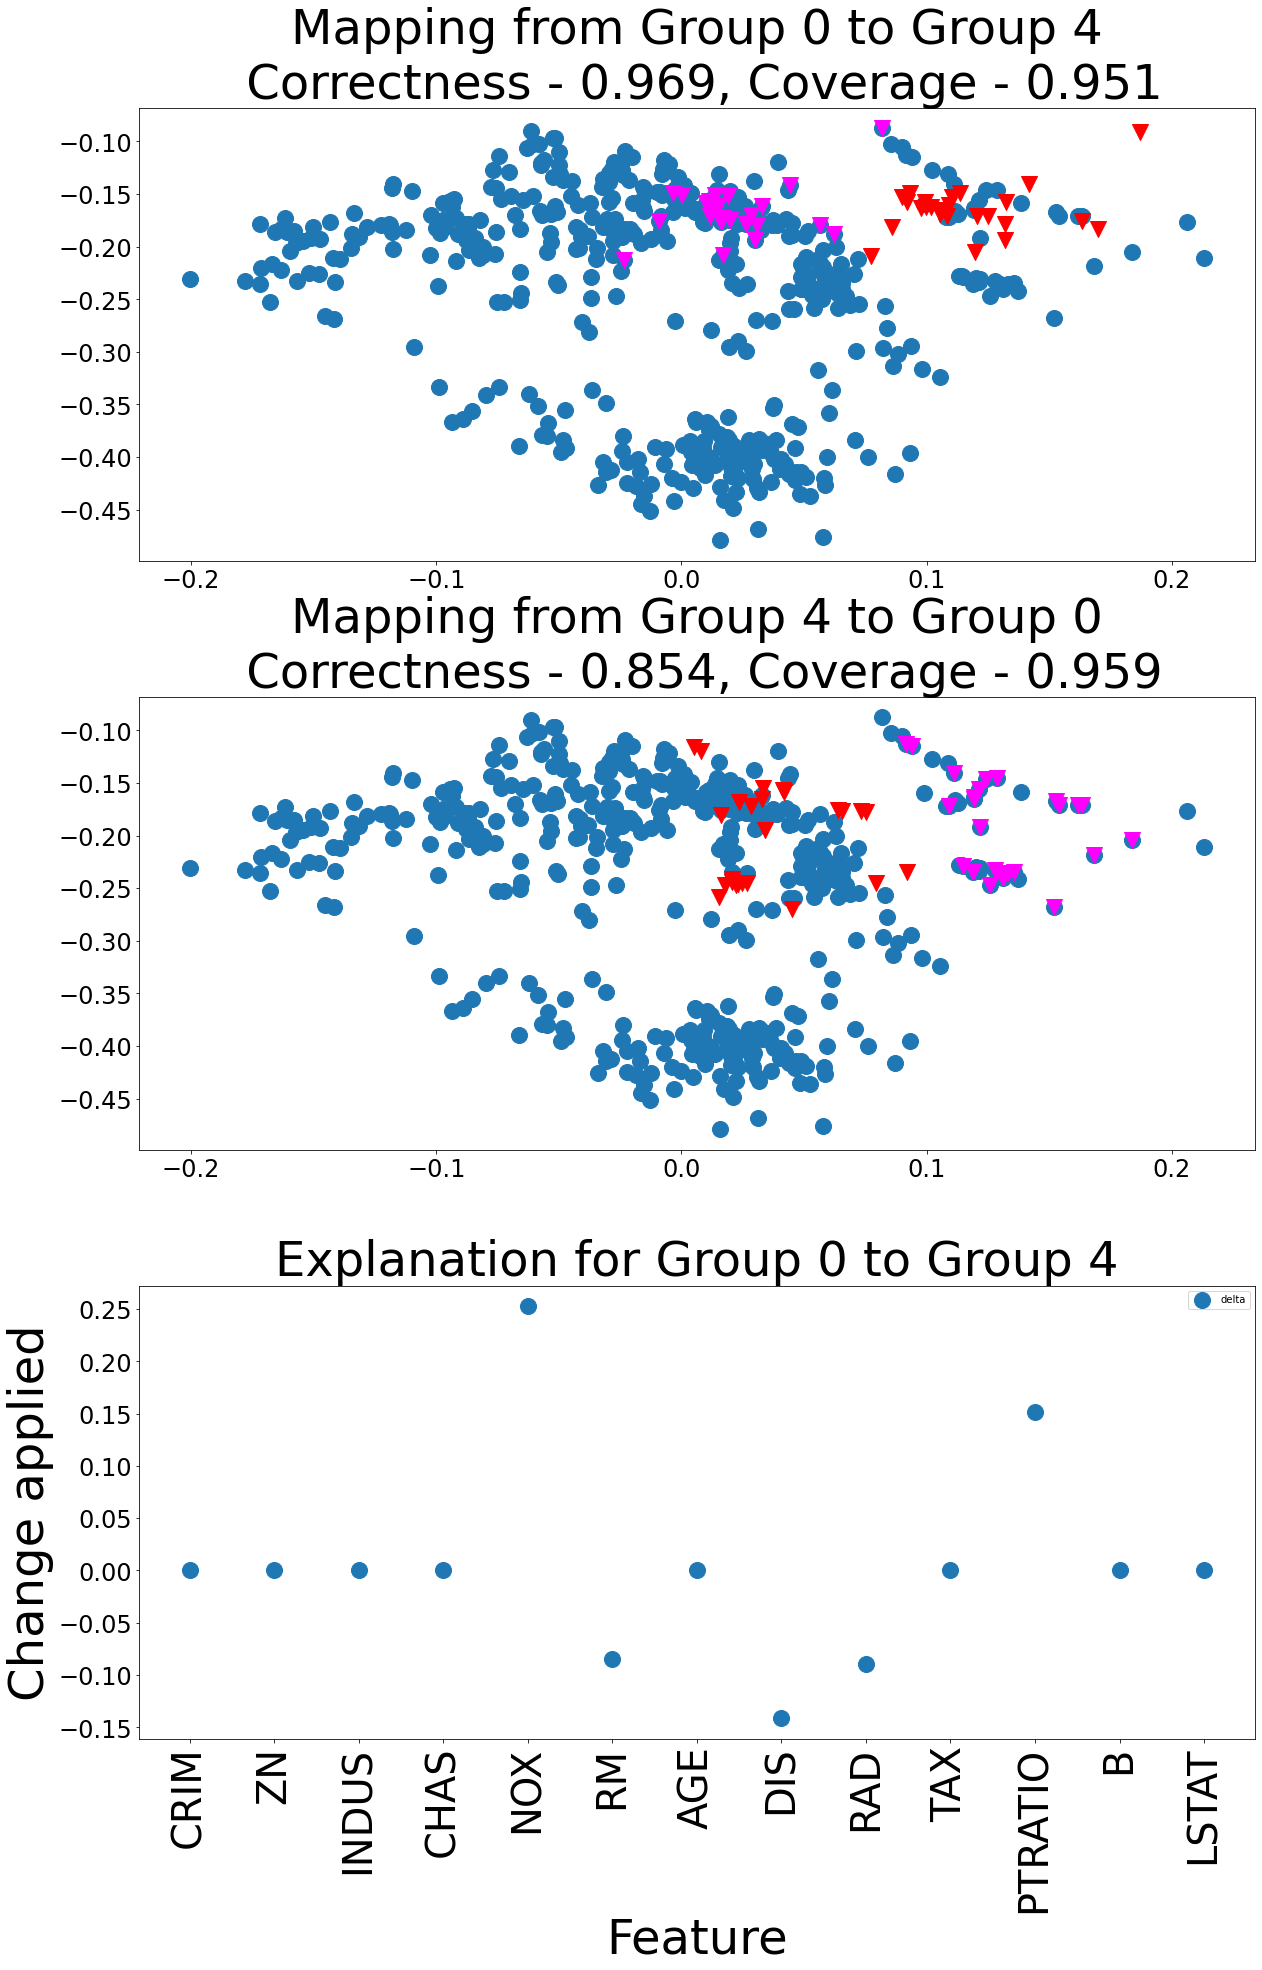

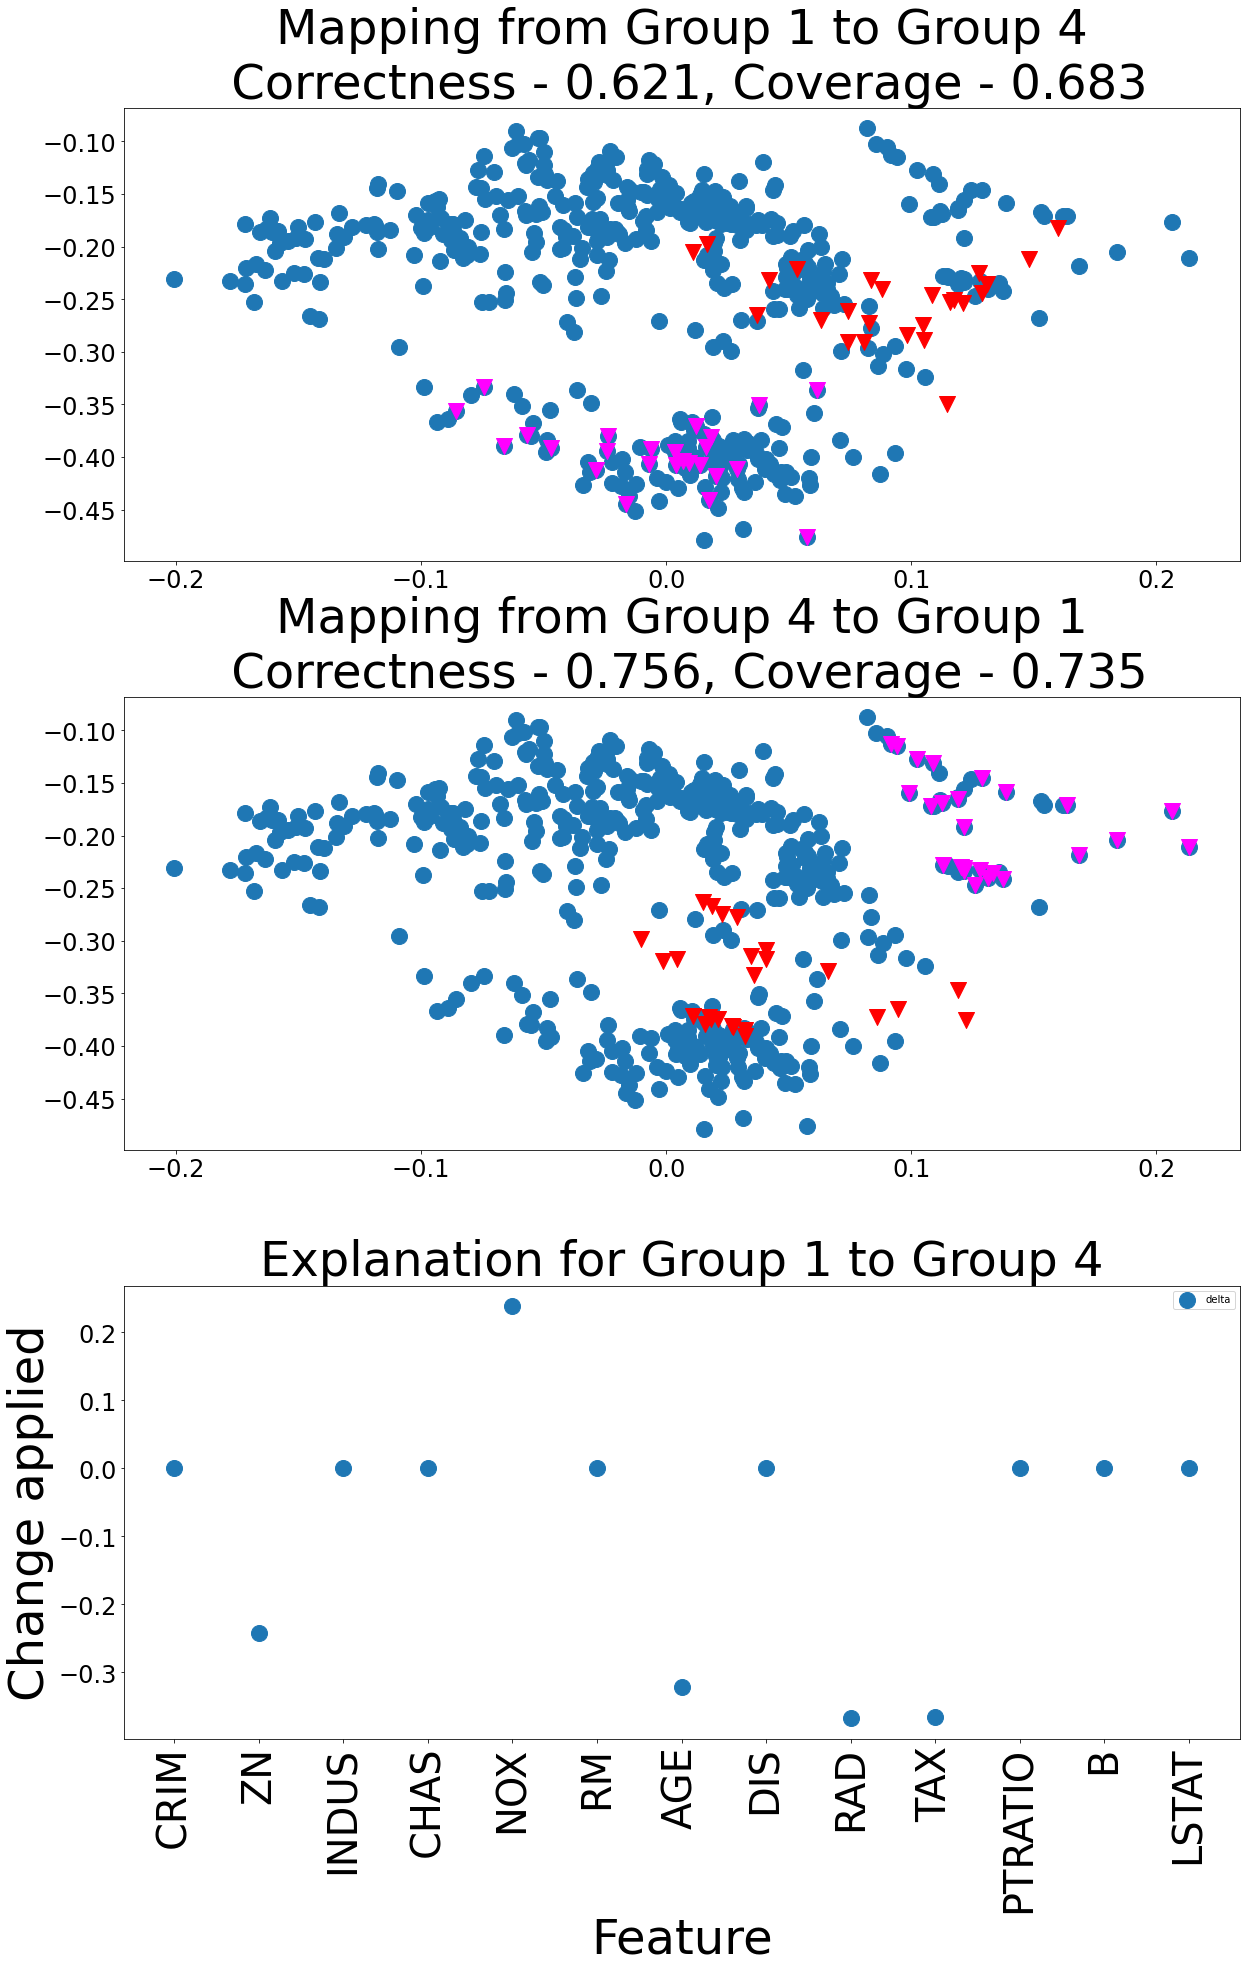

In [15]:
# Evaluate the explanations
# from eldr.plotter.myplot import *
k = 5
epsilon = 0.045
import torch
feature_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

deltas_ = np.load(f"{results_path}deltas" + str(k) + ".npy")
np.set_printoptions(suppress=True)
print(deltas_)

a, b = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas_), epsilon, k = k)

plot_metrics(a, b, name = "housing-metrics.png")

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 2, k = k, num_points = 25, name = "housing-0to2.png", feature_names = feature_names)

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 3, 5, k = k,  num_points = 25, name = "housing-3to5.png", feature_names = feature_names)

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 4, k = k,  num_points = 25, name = "housing-0to4.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 4, k = k,  num_points = 25, name = "housing-1to4.png", feature_names = feature_names)


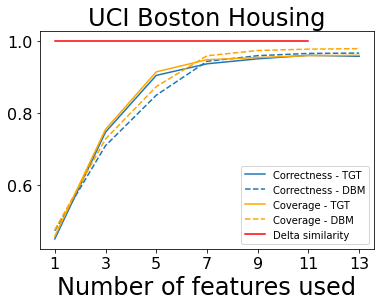

In [16]:
from eldr.misc import load
import matplotlib
matplotlib.rc("xtick", labelsize = 16)
matplotlib.rc("ytick", labelsize = 16)
matplotlib.rc("axes", titlesize = 24)
matplotlib.rc("axes", labelsize = 24)
out_path = f'{base_path}experiments/Housing/out.csv'
out = np.loadtxt(out_path, delimiter=",")
S_deltas = np.zeros(len(K) - 1)
S_range = []
for c in range(len(K) - 1):
    k_more = K[c]
    k_less = K[c + 1]
    
    d_more = np.load(f"{results_path}deltas" + str(k_more) + ".npy")
    d_less = np.load(f"{results_path}deltas" + str(k_less) + ".npy")
    
    res_deltas = np.ones((num_clusters, num_clusters))
    
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                e_d_more = load(d_more, k_more, i, j).numpy()
                e_d_less = load(d_less, k_less, i, j).numpy()
                
                res_deltas[i,j] = Explainer.similarity(e_d_more, e_d_less)
    S_deltas[c] = np.mean(res_deltas)
    S_range.append(k_more)

plt.plot(out[:, 0], out[:, 1], c = "C0", label = "Correctness - TGT")
plt.plot(out[:, 0], out[:, 3], ls = "--", c= "C0", label = "Correctness - DBM")
plt.plot(out[:, 0], out[:, 2], c = "orange", label = "Coverage - TGT")
plt.plot(out[:, 0], out[:, 4], ls = "--", color = "orange", label = "Coverage - DBM")
plt.plot(S_range, S_deltas, c = 'red', label='Delta similarity')

plt.xlabel('Number of features used')
plt.title('UCI Boston Housing')
plt.xticks(np.arange(1, 15, step=2))
plt.legend()

plt.savefig("housing-tradeoff.png", bbox_inches='tight')
plt.show()
plt.close()